## The Efficientnet model development and fine tuning

in this notebook we will load and add our layers to the base model of the pre-trained EfficientnetB7 model, and fine tune the following parameters of the model:
1. **Optimizers** - We will use only 5 optimizers to see which one works best, namely; 1. `SGD`,2. `RMSprop`,3. `Adam`,4. `Adagrad`,5. `Adadelta`. the best optimizer will be used in the New model
2. **Number of epochs** - We will also use only 4 epochs to choose the best performer namely; `1, 2, 5, 10`.
3. **Batch size** - we will also use these batch sizes to choose the optimum batch size, namely; `8, 16`. 
4. **Dropout** - we will optimise the dropout of the model, values `0.5, 0.6, 0.7, 0.8, 0.9`

> **Section one:** we will create common function and also create our base model, with the following initial parameters: **Batch size** `8`, **Optimizer** `Adam`, **Number of epochs** `4`, **dropout value** `0.5`. 

# **Import libraries that we will use**

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import efficientnet.keras as efn 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
import tqdm.gui as tqdm
import tqdm.notebook as tqdm

In [ ]:
from tensorflow.keras.layers import Activation, Dense

# **Common functions**

In [ ]:
# common functions that i will use

def get_data_generator(train_data_path, \
                       val_data_path, \
                       targetsize, \
                       classmode, \
                       batchsize):
    """
    This function is a data generator function for train, validation, and testing data
    Inputs
        train_data_path   : train data path for the dataset 
        val_data_path     : validation data path for the dataset
        targetsize        : target size for the generator to resize all images to, (224,224)
        classmode         : class mode, 'categorical'
        batchsize         : batch size
    Outputs
        train_generator   : generated train data
        val_generator     : generated validation data
    
    """
    train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    
    train_generator=train_datagen.flow_from_directory(train_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    
    val_generator=val_datagen.flow_from_directory(val_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
 
    return train_generator,val_generator   
    


def train_evaluate_the_model(train_generator, \
                             val_generator, \
                             optimizer, \
                             epochs, \
                             dropout_value, \
                             TheModel):
    '''
    train the model, do predictions, and do evaluation and return the accuracy of the model
    Inputs
        train_generator : generated train data
        val_generator   : generated validation data
        optimizer       : the optimizer method used to compile the model
        epochs          : the epochs of the model use to fit the model
        dropout_value   : the dropout value
        TheModel        : The pretrained model loaded,
    Outputs
        accuracy        : The accuracy of the model
    '''
    # load pretrained model and add layers on top of the model
    x = TheModel.output
    x = tf.keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_value)(x)
    predictions = Dense(4, activation="sigmoid")(x)
    model = Model(inputs = TheModel.input, outputs = predictions)
    
    # freeze base layers for training
    for layer in TheModel.layers:
        layer.trainable = False
    
    # compile the model
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    step_size_train=train_generator.n//train_generator.batch_size
    # fit the model
    r = model.fit_generator(generator=train_generator,
                        validation_data=val_generator,
                        steps_per_epoch=step_size_train,
                        epochs=epochs)
    # valuate the model
    scores = model.evaluate(val_generator)
    accuracy = scores[1]*100
    
    return accuracy, model

# **Load and generate data**

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

'''
Initial and constant parameters for the model
initial parameters
       batch_size    : the initial batch size we will create our base model with
Constant parameters
       target_size   : Constant image target size for the whole notebook which is (224,224)
       class_mode    : class mode we will use for the whole notebook, which is 'categorical'
'''
# constant parameters
targetsize_constant = (224,224)
classmode_constant = 'categorical'

# initial parameters
batchsize_initial = 8
epochs_initial = 4
dropout_value_initial = 0.5
optimizer_initial = 'Adam'

# Data paths
train_dataset_path = 'Dataset/Training/'
validation_dataset_path = 'Dataset/Validation/'
test_dataset_path = 'Dataset/Testing/'


train_generator_initial = train_datagen.flow_from_directory(train_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)
val_generator_initial = val_datagen.flow_from_directory(validation_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
# display classes found in the data
train_generator_initial.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# **Import the EfficientnetB7 base model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
image_size = [224,224] # choose image size
# import the base model
efnB7 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape= image_size+[3],weights='imagenet',include_top=False)

# storing the base model in the kernel for later use to avoid loading many times
efnB7_basemodel = efnB7


#### Add layers on top of the base model

In [ ]:
# initial parameter value
dropout_value_initial = 0.1

# add layers
x = efnB7.output
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(dropout_value_initial)(x)
predictions = Dense(4, activation="sigmoid")(x)
model = Model(inputs = efnB7.input, outputs = predictions)

'\n# add layers\nx = efnB7.output\nx = tf.keras.layers.Flatten()(x)\nx = Dense(1024, activation="relu")(x)\nx = Dense(1024, activation="relu")(x)\nx = Dense(512, activation="relu")(x)\nx = tf.keras.layers.Dropout(dropout_value_initial)(x)\npredictions = Dense(4, activation="sigmoid")(x)\nmodel = Model(inputs = efnB7.input, outputs = predictions)'

In [ ]:
# freeze base layers for training
for layer in efnB7.layers:
    layer.trainable = False

# **Compile the model**

In [ ]:
# initial optimizer
optimizer_initial = 'Adam'

# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

"\n# compile the model\nmodel.compile(optimizer=optimizer_initial,\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])"

# **Fit the model**

In [ ]:
# initial parameters
epochs_initial = 4
step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size # computing the steps size per epoch

tic = time.time()
# fit the model
r = model.fit_generator(generator=train_generator_initial,
                        validation_data=val_generator_initial,
                        steps_per_epoch=step_size_train_initial,
                        epochs=epochs_initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
358/358 [==============================] - 1367s 4s/step - loss: 2.3466 - accuracy: 0.6600 - val_loss: 0.4941 - val_accuracy: 0.8362
Epoch 2/4
358/358 [==============================] - 1448s 4s/step - loss: 0.4798 - accuracy: 0.8298 - val_loss: 0.2534 - val_accuracy: 0.9045
Epoch 3/4
358/358 [==============================] - 1494s 4s/step - loss: 0.3648 - accuracy: 0.8676 - val_loss: 0.3082 - val_accuracy: 0.8895
Epoch 4/4
358/358 [==============================] - 1431s 4s/step - loss: 0.2838 - accuracy: 0.8941 - val_loss: 0.1202 - val_accuracy: 0.9544
Minutes taken = 95.67590473890304


# **Evaluate the model**

In [ ]:
# evaluation on validation data
scores = model.evaluate(val_generator_initial)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))


359/359 [==============================] - 621s 2s/step - loss: 0.1202 - accuracy: 0.9544
evaluate accuracy: 95.44%


# **Section two:** We will start fine tunning

## **Tunning optimizers of the model**

In [ ]:
param_label = 'optimizer'
param_list = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta'] # ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,param,epochs_initial,dropout_value_initial,efnB7_basemodel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

Epoch 1/4
358/358 [==============================] - 1339s 4s/step - loss: 2.5084 - accuracy: 0.6908 - val_loss: 0.4476 - val_accuracy: 0.8220
Epoch 2/4
358/358 [==============================] - 1317s 4s/step - loss: 0.4882 - accuracy: 0.8281 - val_loss: 0.2847 - val_accuracy: 0.8815
Epoch 3/4
358/358 [==============================] - 1329s 4s/step - loss: 0.3549 - accuracy: 0.8742 - val_loss: 0.2113 - val_accuracy: 0.9174
Epoch 4/4
359/359 [==============================] - 613s 2s/step - loss: 0.5367 - accuracy: 0.8749
Epoch 1/4
358/358 [==============================] - 1294s 4s/step - loss: 0.8377 - accuracy: 0.6663 - val_loss: 0.5529 - val_accuracy: 0.7780
Epoch 2/4
358/358 [==============================] - 1304s 4s/step - loss: 0.4519 - accuracy: 0.8180 - val_loss: 0.3014 - val_accuracy: 0.8812
Epoch 3/4
358/358 [==============================] - 1298s 4s/step - loss: 0.3445 - accuracy: 0.8648 - val_loss: 0.2320 - val_accuracy: 0.9080
Epoch 4/4
359/359 [=======================

,optimizer,accuracy
0,Adam,87.491292
1,SGD,87.804878
2,RMSprop,87.909406
3,Adagrad,93.031359
4,Adadelta,92.926830


Text(0, 0.5, 'accuracy)')

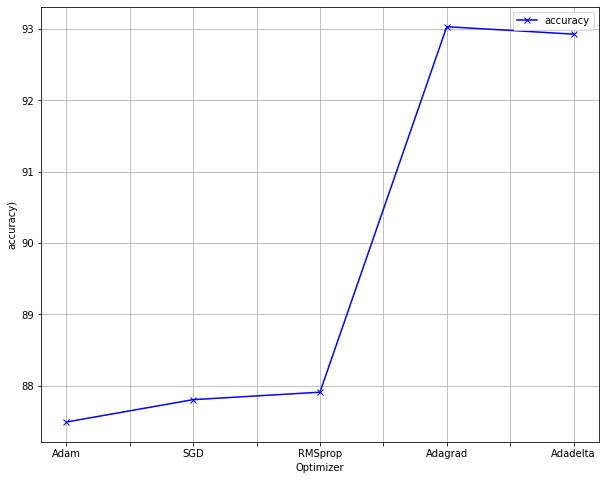

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='optimizer', y='accuracy',style='bx-', grid=True)
ax.set_xlabel("Optimizer")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
optimizer_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(optimizer_opt))

max Accuracy = 93.031
optimum optimizer = Adagrad


# **Tunning dropout of the model**

In [ ]:
param_label = 'dropout_prob'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9]


accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,optimizer_initial,epochs_initial,param,efnB7_basemodel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
358/358 [==============================] - 1345s 4s/step - loss: 3.2620 - accuracy: 0.6565 - val_loss: 0.5753 - val_accuracy: 0.8024
Epoch 2/4
358/358 [==============================] - 1303s 4s/step - loss: 0.5616 - accuracy: 0.7949 - val_loss: 0.3743 - val_accuracy: 0.8585
Epoch 3/4
358/358 [==============================] - 1302s 4s/step - loss: 0.3792 - accuracy: 0.8627 - val_loss: 0.2664 - val_accuracy: 0.8962
Epoch 4/4
359/359 [==============================] - 600s 2s/step - loss: 0.3597 - accuracy: 0.8864
Epoch 1/4
358/358 [==============================] - 1240s 3s/step - loss: 3.4531 - accuracy: 0.6359 - val_loss: 0.5186 - val_accuracy: 0.8230
Epoch 2/4
358/358 [==============================] - 1216s 3s/step - loss: 0.5781 - accuracy: 0.7928 - val_loss: 0.3659 - val_accuracy: 0.8617
Epoch 3/4
358/358 [==============================] - 1217s 3s/step - loss: 0.4623 - accuracy: 0.8417 - val_loss: 0.3268 - val_accuracy: 0.8972
Epoch 4/4
359/359 [=======================

,dropout_prob,accuracy
0,0.5,88.641113
1,0.6,89.616722
2,0.7,83.484322
3,0.8,88.083625
4,0.9,57.770038


Text(0, 0.5, 'accuracy)')

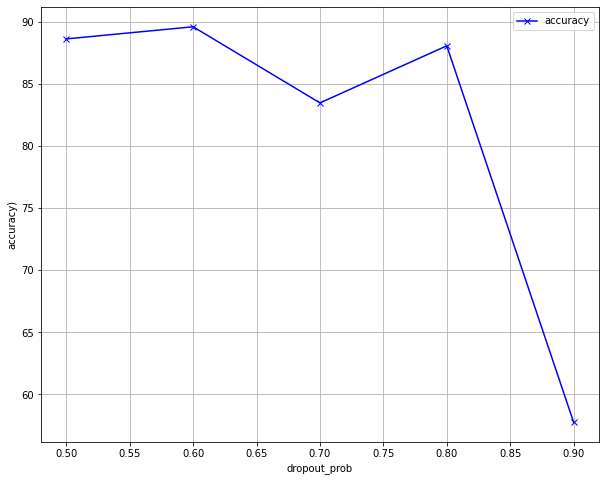

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='dropout_prob', y='accuracy',style='bx-', grid=True)
ax.set_xlabel("dropout_prob")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
dropout_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(dropout_opt))

max Accuracy = 89.617
optimum dropout_prob = 0.6


# **Tuning batch size and epochs of the model**

In [ ]:
param_label = 'epochs'
param_list = [1,2,5,10] # [5, 10, 15, 20]

param2_label = 'batch_size'
param2_list = [8, 16] # [8, 16, 32] am using this batch sizes for now until we fix the accuracy issue, proper batch sizes to be use [8, 16, 32, 64, 128]

accuracy_table = {param_label: [], param2_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        
        # generate train and validation data
        train_generator,val_generator, _ = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, param2)
        # train, predict and evaluate model
        accuracy, _ = train_evaluate_the_model(train_generator, val_generator, optimizer_initial, param,dropout_value_initial, efnB7_basemodel)
        
        # collect results
        accuracy_table[param_label].append(param)
        accuracy_table[param2_label].append(param2)
        accuracy_table['accuracy'].append(accuracy)
        
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

<ipython-input-13-222ed610b3e2>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


359/359 [==============================] - 620s 2s/step - loss: 0.5212 - accuracy: 0.8254
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
180/180 [==============================] - 598s 3s/step - loss: 0.5190 - accuracy: 0.7955



Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
358/358 [==============================] - 1371s 4s/step - loss: 3.2866 - accuracy: 0.6408 - val_loss: 0.5142 - val_accuracy: 0.8007
Epoch 2/2
359/359 [==============================] - 628s 2s/step - loss: 0.3039 - accuracy: 0.8937
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
179/179 [==============================] - 1294s 7s/step - loss: 4.6496 - accuracy: 0.6503 - val_loss: 0.5415 - val_accuracy: 0.7596
Epoch 2/2
180/180 [==============================] - 602s 3s/step - loss: 0.2805 - accuracy: 0.8948



Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
358/358 [==============================] - 1420s 4s/step - loss: 3.1804 - accuracy: 0.6663 - val_loss: 0.4951 - val_accuracy: 0.8125
Epoch 2/5
358/358 [==============================] - 1388s 4s/step - loss: 0.5633 - accuracy: 0.8078 - val_loss: 0.3516 - val_accuracy: 0.8746
Epoch 3/5
358/358 [==============================] - 1383s 4s/step - loss: 0.3921 - accuracy: 0.8585 - val_loss: 0.2836 - val_accuracy: 0.8913
Epoch 4/5
358/358 [==============================] - 1384s 4s/step - loss: 0.3123 - accuracy: 0.8871 - val_loss: 0.1842 - val_accuracy: 0.9286
Epoch 5/5
359/359 [==============================] - 630s 2s/step - loss: 0.1391 - accuracy: 0.9554
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
179/179 [==============================] - 1248s 7s/step - loss: 3.9

Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10
358/358 [==============================] - 1431s 4s/step - loss: 3.3611 - accuracy: 0.6419 - val_loss: 0.6146 - val_accuracy: 0.7265
Epoch 2/10
358/358 [==============================] - 1425s 4s/step - loss: 0.6329 - accuracy: 0.7771 - val_loss: 0.3551 - val_accuracy: 0.8662
Epoch 3/10
358/358 [==============================] - 1404s 4s/step - loss: 0.4571 - accuracy: 0.8421 - val_loss: 0.4095 - val_accuracy: 0.8561
Epoch 4/10
358/358 [==============================] - 1405s 4s/step - loss: 0.4033 - accuracy: 0.8679 - val_loss: 0.2233 - val_accuracy: 0.9118
Epoch 5/10
358/358 [==============================] - 1408s 4s/step - loss: 0.3438 - accuracy: 0.8847 - val_loss: 0.2563 - val_accuracy: 0.9105
Epoch 6/10
358/358 [==============================] - 1406s 4s/step - loss: 0.2772 - accuracy: 0.9039 - val_loss: 0.1500 - val_accuracy: 0.9449
Epoch 7/10


,epochs,batch_size,accuracy
0,1,8,82.543552
1,1,16,79.547036
2,2,8,89.372820
3,2,16,89.477354
4,5,8,95.540071
5,5,16,94.912893
6,10,8,95.052266
7,10,16,97.770035


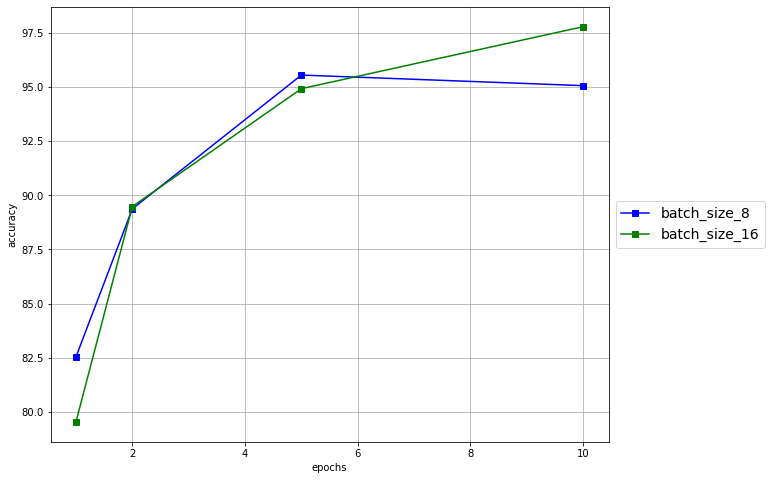

In [ ]:
from pylab import rcParams

# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = accuracy_table[accuracy_table[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='accuracy', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', '0.75']
for i in range(1,len(param2_list)):
    temp = accuracy_table[accuracy_table[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='accuracy', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("accuracy")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [ ]:
# Get optimum value for param and param2
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

max Accuracy = 97.770
optimum epochs = 10
optimum batch_size = 16


In [ ]:
######
dropout_opt = 0.6
batch_size_opt = 16
epochs_opt = 10
optimizer_opt = 'Adagrad'
#####

# **Collecting all optimum tunned parameters**

In [ ]:
d = {'param': ['optimizer', 'epochs', 'batch_size','dropout_prob'],
     'original': [optimizer_initial, epochs_initial, batchsize_initial,dropout_value_initial],
     'after_tuning': [optimizer_opt, epochs_opt, batch_size_opt,dropout_opt]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,optimizer,Adam,Adagrad
1,epochs,4,10
2,batch_size,8,16
3,dropout_prob,0.5,0.6


# **Creating the final model with optimum parameters**

In [ ]:
# get train and validation data generator
train_generator_opt,val_generator_opt,test_generator_opt = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, batch_size_opt)

# train and evaluate the model
accuracy, New_model = train_evaluate_the_model(train_generator_opt, val_generator_opt, optimizer_opt, epochs_opt,dropout_opt , efnB7_basemodel)


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
179/179 [==============================] - 1324s 7s/step - loss: 0.8610 - accuracy: 0.6405 - val_loss: 0.4861 - val_accuracy: 0.8010
Epoch 2/10
179/179 [==============================] - 1328s 7s/step - loss: 0.5183 - accuracy: 0.8024 - val_loss: 0.3342 - val_accuracy: 0.8746
Epoch 3/10
179/179 [==============================] - 1337s 7s/step - loss: 0.3949 - accuracy: 0.8542 - val_loss: 0.2442 - val_accuracy: 0.9038
Epoch 4/10
179/179 [==============================] - 1335s 7s/step - loss: 0.3253 - accuracy: 0.8781 - val_loss: 0.1651 - val_accuracy: 0.9481
Epoch 5/10
179/179 [==============================] - 1339s 8s/step - loss: 0.2588 - accuracy: 0.9036 - val_loss: 0.1493 - val_accuracy: 0.9495
Epoch 6/10
179/179 [==============================] - 1347s 8s/step - loss: 0.2343 - accuracy: 0.9135 - val_loss: 0.1214 - val_accuracy: 0.9690
Epoch 7/10
179/179 [==============================] - 1345s 8s/step - loss: 0.1878 - accuracy: 0.9310 - val_loss: 0.1240 - val_accuracy:

In [ ]:
accuracy

98.18815588951111

# **Save the model**

In [ ]:
New_model.save('brain_tumor_classification_efnB7_test10091335.hdf5') #28060904 - dd/mm/hours/minutes

C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# ---------------------------------------- END OF NOTEBOOK -----------------------------------
